# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [4]:
# Installing the libraries with the specified version.
!pip install tensorflow==2.17 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.26.0 pandas==2.1.4 opencv-python==4.8.0.76 -q --user

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [5]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/Colab Notebooks/images.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Labels.csv')

## Data Overview

### Understand the shape of the dataset

In [8]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


There are 4,750 RGB images of shape 128 x 128 x 3, each having 3 channels

In [9]:
# Visualize the first five rows of the label data
labels.head()

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [10]:
def plot_images(images,labels):
  num_classes=12                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

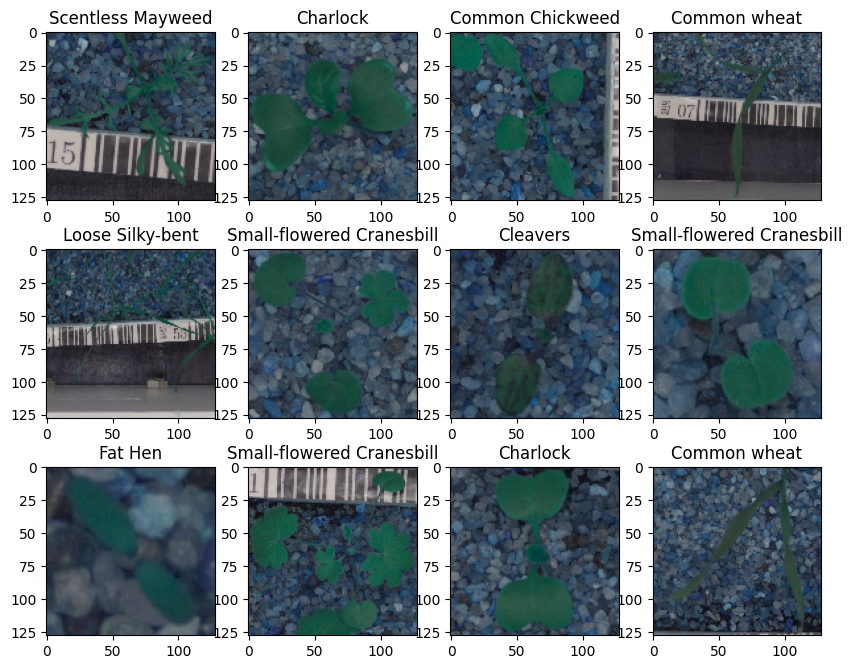

In [11]:
plot_images(images,labels)

The different categories of plant images look quite different from each other

**Checking for data imbalance**

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 [Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500'),
  Text(600.0, 0, '600'),
  Text(700.0, 0, '700')])

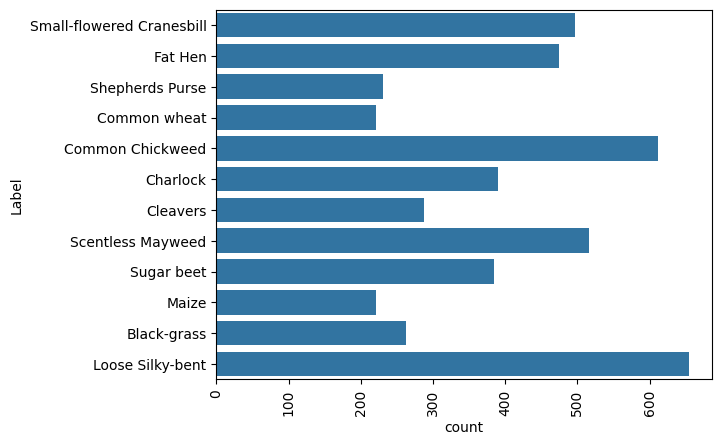

In [12]:
 sns.countplot(labels['Label'])
 plt.xticks(rotation='vertical')



*   The dataset appears to be slightly unbalanced
*   'Loose Silky-bent' and 'Common Chickweed' plants have more images than the rest of the plants



## Data Pre-Processing

### Convert the BGR images to RGB images.

In [13]:
# Convert the image to RGB format
images_rgb = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [14]:
# Resize the images to 64x64 pixels
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images_rgb)):
   # Resize the image to the specified dimensions and add it to the list
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

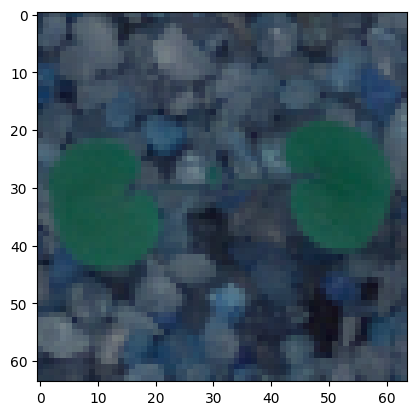

In [15]:
plt.imshow(images_decreased[0])

### Visualizing Images using Gaussian Blur

In [16]:
# Applying Gaussian Blur to remove noise the images
images_gb=[]
for i in range(len(images)):
  # gb[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
  images_gb.append(cv2.GaussianBlur(images[i], ksize =(3,3),sigmaX =  0))

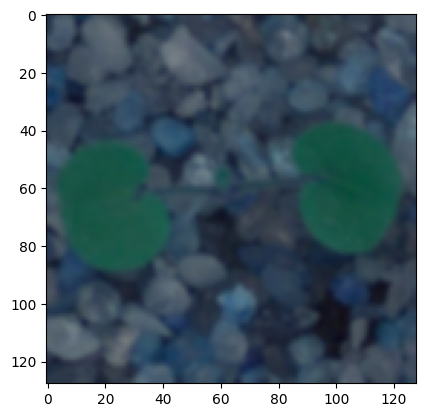

In [17]:
plt.imshow(images_gb[0])

NOTE: The GaussianBlur seems ineffective as the resulted image does not contain any relevant/new information.

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

*   Let's split the dataset into 10% testing, and from the rest 90%; 80% for training and 10% for validation

In [18]:
# Using train_test_split function from scikit learn to split the data
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.125, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.125, random_state=42,stratify=y_temp)

In [19]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3636, 64, 64, 3) (3636, 1)
(520, 64, 64, 3) (520, 1)
(594, 64, 64, 3) (594, 1)


### Encode the target labels

In [20]:
# Use the Labelbinarizer encoding method
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

### Data Normalization

In [21]:
# Normalizing the image pixels by dividing all pixel values by 255 to standardize the images to 0-1
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## Model Building

Let's create a CNN model sequentially, where we will be adding the layers one after another.

First, we need to clear the previous model's history from the session even if a single model can run multiple times on the same data.

Then set the seed for random number generator in Numpy, the random library in Python

In [22]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [23]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Now, let's build a **CNN Model** with the following 2 main parts - <br>

1. **The Feature Extraction layers** which are comprised of convolutional and pooling layers.
2. **The Fully Connected classification layers** for prediction.<br><br>

In [24]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.15))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │         131,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 151,548 (591.98 KB)

 Trainable params: 151,548 (591.98 KB)

 Non-trainable params: 0 (0.00 B)

### Fitting the model on the train data

In [25]:
history_1 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
114/114 - 12s - 105ms/step - accuracy: 0.1799 - loss: 2.3762 - val_accuracy: 0.3462 - val_loss: 2.1434
Epoch 2/30
114/114 - 11s - 92ms/step - accuracy: 0.3210 - loss: 2.0210 - val_accuracy: 0.4038 - val_loss: 1.8310
Epoch 3/30
114/114 - 1s - 7ms/step - accuracy: 0.3487 - loss: 1.8467 - val_accuracy: 0.4288 - val_loss: 1.6854
Epoch 4/30
114/114 - 1s - 11ms/step - accuracy: 0.3716 - loss: 1.7457 - val_accuracy: 0.4327 - val_loss: 1.6351
Epoch 5/30
114/114 - 1s - 10ms/step - accuracy: 0.4026 - loss: 1.6540 - val_accuracy: 0.4788 - val_loss: 1.5375
Epoch 6/30
114/114 - 1s - 5ms/step - accuracy: 0.4087 - loss: 1.6152 - val_accuracy: 0.5038 - val_loss: 1.4507
Epoch 7/30
114/114 - 1s - 5ms/step - accuracy: 0.4373 - loss: 1.5389 - val_accuracy: 0.5327 - val_loss: 1.3936
Epoch 8/30
114/114 - 1s - 5ms/step - accuracy: 0.4612 - loss: 1.4957 - val_accuracy: 0.5288 - val_loss: 1.3249
Epoch 9/30
114/114 - 1s - 6ms/step - accuracy: 0.4675 - loss: 1.4757 - val_accuracy: 0.5577 - val_loss: 1

### Model Evaluation

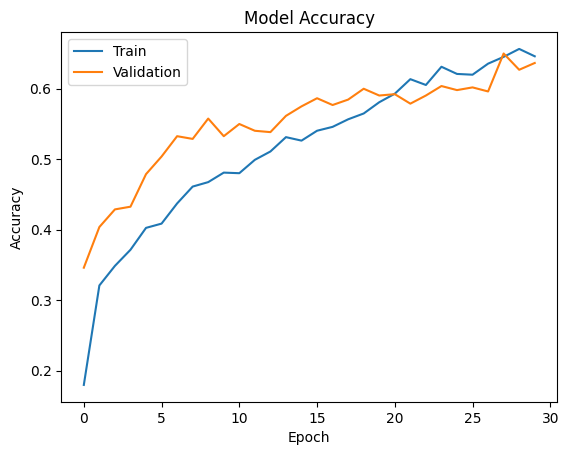

In [26]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observation:**

*   We can observe from the plot that the training accuracy (64.6%) of the model is slightly better than the validation accuracy (63.7%) of the model.

### Evaluate the model on test data

In [27]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

19/19 - 1s - 32ms/step - accuracy: 0.6010 - loss: 1.3029


**Obesravtion**
- The testing accuracy of the model is 60.1%

### Generating the prediction using test data

In [28]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [29]:
y_pred

array([[2.3021373e-01, 2.2467157e-07, 1.4224742e-04, ..., 9.6274796e-08,
        3.4282050e-07, 6.0712057e-03],
       [3.5915751e-02, 2.8209167e-03, 5.5822253e-02, ..., 8.2982710e-04,
        3.5710626e-03, 1.9381076e-01],
       [1.2560602e-02, 7.6986864e-05, 1.4565003e-02, ..., 5.7029538e-03,
        3.3313398e-05, 4.0045865e-02],
       ...,
       [2.1027077e-10, 3.6059949e-01, 4.4919655e-01, ..., 1.1099984e-01,
        7.8315157e-03, 2.9015630e-02],
       [1.2984650e-05, 1.7934615e-03, 6.1549542e-08, ..., 1.5221702e-01,
        2.2261178e-03, 4.3393904e-03],
       [8.8527129e-04, 1.5347725e-07, 6.9248253e-03, ..., 9.5429838e-05,
        1.5872289e-05, 4.3055569e-03]], dtype=float32)

### Plotting the Confusion Matrix

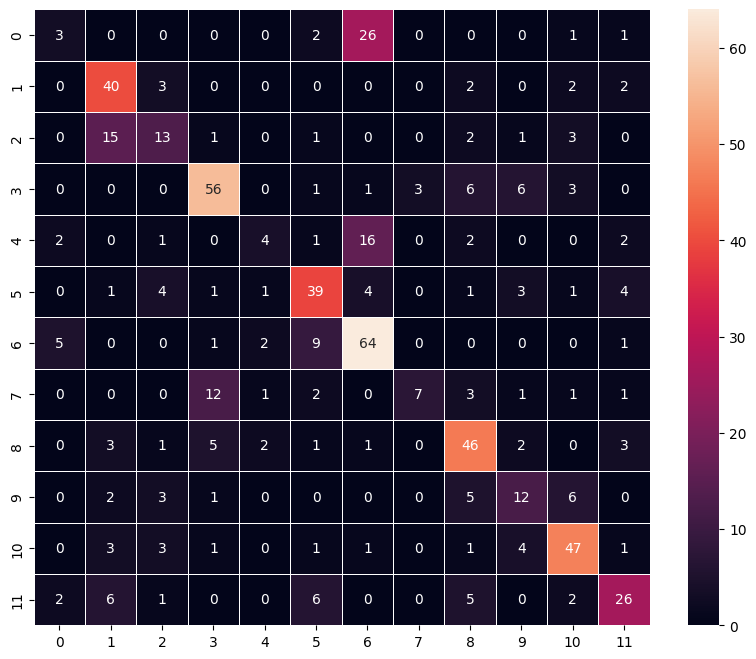

In [30]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

**Observations**
*   We observe that there are a good amount of the classes that are not predicted correctly.
*   We notice that there is a high occurrence of class 6 being predicted as class 0;  class 6 being predicted as class 4; class 1 being predicted as class 1..


## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [63]:
# Clearing backend
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [64]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )
# test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

In [65]:
# Intializing a sequential model
new_model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
new_model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
new_model.add(MaxPooling2D((2, 2), padding = 'same'))
# model.add(BatchNormalization())
new_model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
new_model.add(MaxPooling2D((2, 2), padding = 'same'))
new_model.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
new_model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
new_model.add(Dense(18, activation='relu'))
new_model.add(Dropout(0.3))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
new_model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 18)                  │         147,474 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 18)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             228 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 168,086 (656.59 KB)

 Trainable params: 168,022 (656.34 KB)

 Non-trainable params: 64 (256.00 B)

In [66]:
# Setting up the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitors the validation loss
    factor=0.5,          # Reduces the learning rate by a factor of 0.5
    patience=5,          # Wait for 5 epochs before reducing the learning rate
    min_lr=1e-6          # Sets a minimum learning rate
)

In [67]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

history = new_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1,
                    callbacks=[reduce_lr])

Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.1418 - loss: 2.4534 - val_accuracy: 0.1923 - val_loss: 2.4236 - learning_rate: 0.0010
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3438 - loss: 1.9057 - val_accuracy: 0.2462 - val_loss: 2.4090 - learning_rate: 0.0010
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.3774 - loss: 1.8350 - val_accuracy: 0.2462 - val_loss: 2.3361 - learning_rate: 0.0010
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5000 - loss: 1.5123 - val_accuracy: 0.2308 - val_loss: 2.3466 - learning_rate: 0.0010
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.4583 - loss: 1.5726 - val_accuracy: 0.1519 - val_loss: 2.2429 - learning_rate: 0.0010
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5312 - loss: 1.3176 - val_accuracy: 0.1423 - val_loss: 2.2505 - learning_rate: 0.0010
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.5438 - loss: 1.3781 - val_acc

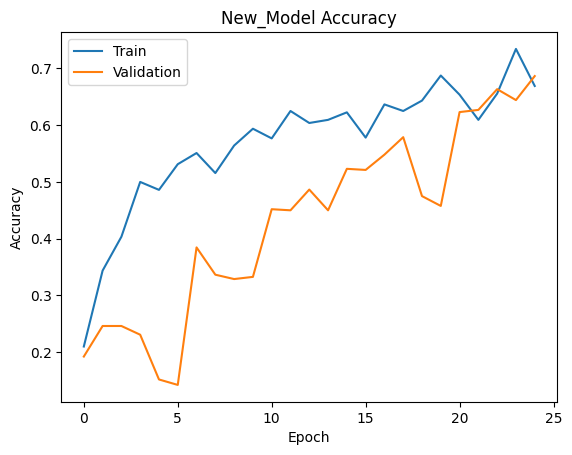

In [68]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('New_Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Observation**

*   The accuracy of this model is better than the initial model accuracy with training being 66.8% and validation being 68.7%. Therefore, we can say that the data augmentation helped improve the model.



In [69]:
accuracy = new_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

19/19 - 0s - 24ms/step - accuracy: 0.6566 - loss: 0.9770


**Observation**
- Testing accuracy is 65.7


**Observations**
* The model has 66.8% accuracy on the testing data and performed better than
previous model.
* Also, the accuracies of the training, validation, & testing are all within a close rangeto one another indicating that the model in generalized.

In [54]:
y_pred=new_model.predict(X_test_normalized)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


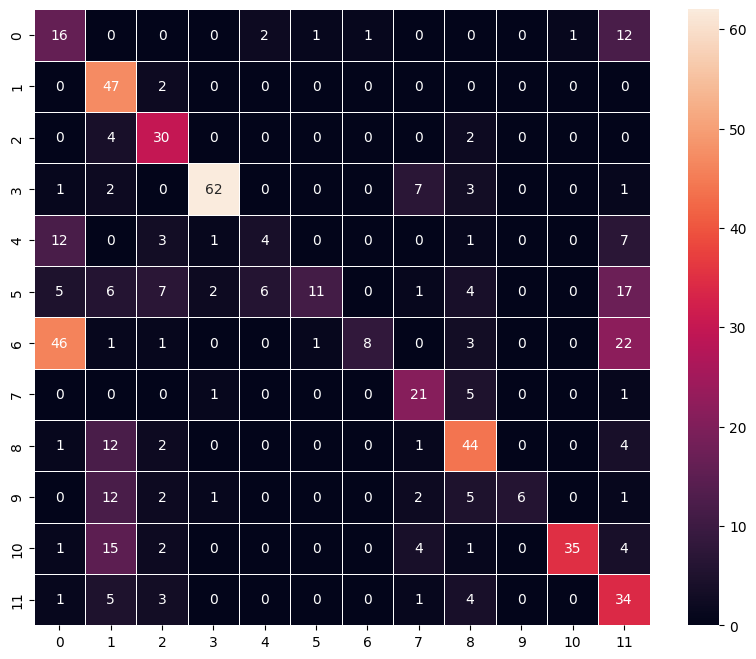

In [55]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

**Observations**
* The confusion matrix appears to be improving as well, however there is still some confusion with some of the classes of plant types.
* The 1st class is the most confused class among all.
* We can observe that this model has outperformed our previous model.

## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

* According to the confusion matrix and accuracy curve, the second model (**new_model**) has outperformed the first.
* Thus we can say that '**new_model**' is our best model and we can use this model to predict and visualize some test images.

### Visualizing the prediction

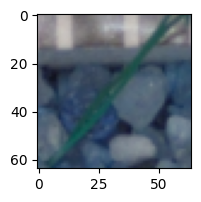

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
Predicted Label ['Scentless Mayweed']
True Label Loose Silky-bent


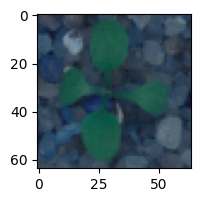

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Label ['Shepherds Purse']
True Label Shepherds Purse


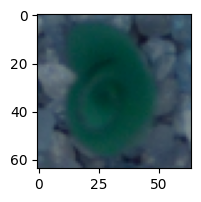

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Label ['Maize']
True Label Maize


In [40]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

## Actionable Insights and Business Recommendations

* We can observe from the confusion matrix of all thbothe models that the '**new_model**' was the best model because it predicted the majority of the classes better than the other models.
* The test accuracy of the '**new-model**' is 65.7%.
* Data Augmentation has also helped in improving the model.

In [70]:
pd.DataFrame({'Models':['Base CNN Model','CNN Model with Data Augmentation'],'Train Accuracy':['65.9%','66.8%'],'Validation Accuracy':['63.7%','68.7%'],'Test Accuracy':['60.1%','65.7%']})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,Base CNN Model,65.9%,63.7%,60.1%
1,CNN Model with Data Augmentation,66.8%,68.7%,65.7%


### Scope of Improvement
- Transfer Learning architectures can  be used to train the CNN model and these models can be used for classification.
- These models can be further improved by training with different filter sizes and different number of filters.
- These models can also be trained on the original image_size i.e 128 x 128 rather than being reduced to 64.
- Data Augmentation can be performed more and dropout_rate can be changed to improve the model performance.


_____